<p style="text-align: center; font-size:60px;">
<b>Latent Space Recipe</b><br>
</p>

This notebook provides the code to produce the latent space using weights trained from the original Conditional Autoencoder (CAE) from Nate Woodward's ECON AE training code 

<p style="color:lightblue; text-align: center;">
<b> https://github.com/nswood/ECON_AE_Training/tree/master</b><br>
</p>

In [ ]:
import subprocess
import sys

def install(package, upgrade=False, use_alt=False):
    try:
        command = [sys.executable, "-m", "pip", "install"]
        if upgrade:
            command.append("--upgrade")
        command.append(package)
        subprocess.check_call(command)
    except subprocess.CalledProcessError as e:
        print(f"Error installing package {package}: {e}")

install("pip", upgrade=True)
install("setuptools", upgrade=True)

required_packages = [
    "uproot", "awkward","qkeras",
    "tensorflow-model-optimization", "umap-learn",
    "numpy", "pandas", "matplotlib", "scikit-learn"
]

for package in required_packages:
    install(package)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Concatenate
from qkeras import QActivation, QConv2D, QDense, quantized_bits
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import glob
import umap


np.random.seed(42)

# runs operations immediately instead of with graph execution (causes issue if disabled)
tf.config.run_functions_eagerly(True)

## Custom Layers

Extra layers to replicate the original CAE

In [ ]:
# add a zero border so the input lines up with the CAE geometry
class KerasPaddingLayer(tf.keras.layers.Layer):
    def call(self, x):
        padding = tf.constant([[0, 0], [0, 1], [0, 1], [0, 0]]) 
        return tf.pad(x, padding, mode='CONSTANT', constant_values=0)

    def compute_output_shape(self, input_shape):
        batch_size, height, width, channels = input_shape 
        return (batch_size, height + 1, width + 1, channels)


# limit values so nothing goes above a set maximum
class KerasMinimumLayer(tf.keras.layers.Layer):
    def __init__(self, saturation_value=1, **kwargs):
        super(KerasMinimumLayer, self).__init__(**kwargs)
        self.saturation_value = saturation_value

    def call(self, x):
        return tf.minimum(x, self.saturation_value) 

    def compute_output_shape(self, input_shape):
        return input_shape

# force values down to the nearest integer
class KerasFloorLayer(tf.keras.layers.Layer):
    def call(self, x):
        return tf.math.floor(x) 

    def compute_output_shape(self, input_shape):
        return input_shape

## Encoder model setup

Takes wafer + conditions, runs through quantized layers, applies fixed-point packing, then joins latent space with conditions

In [3]:
def build_encoder_model(eLinks=2):
    input_shape = (8, 8, 1)   # wafer input
    condition_shape = (8,)    # condition input

    # map eLinks to quantization bits
    bits_per_outputLink = [0, 1, 3, 5, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
    bits_per_output = bits_per_outputLink[eLinks]

    # encoder inputs
    wafer_input = Input(shape=input_shape, name='Wafer_Input')
    condition_input = Input(shape=condition_shape, name='Condition_Input')

    # encoder backbone
    x = QActivation(activation=quantized_bits(bits=8, integer=1), name='Input_Quantization')(wafer_input)
    x = KerasPaddingLayer(name='Pad')(x)
    x = QConv2D(
        filters=8, kernel_size=3, strides=2, padding='valid',
        kernel_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
        bias_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
        name='Conv2D'
    )(x)
    x = QActivation(activation=quantized_bits(bits=8, integer=1), name='Activation')(x)
    x = Flatten(name='Flat')(x)
    x = QDense(
        units=16,
        kernel_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
        bias_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
        name='Dense_Layer'
    )(x)
    x = QActivation(activation=quantized_bits(bits=9, integer=1), name='Latent_Quantization')(x)
    latent_output = x

    # fixed point packing
    if bits_per_output > 0:
        n_integer_bits = 1
        n_decimal_bits = bits_per_output - n_integer_bits
        output_max_int_size = 1 << n_decimal_bits
        output_saturation_value = (1 << n_integer_bits) - 1. / (1 << n_decimal_bits)

        latent_output = KerasFloorLayer(name='Latent_Floor')(latent_output * output_max_int_size)
        latent_output = KerasMinimumLayer(saturation_value=output_saturation_value, name='Latent_Clip')(latent_output / output_max_int_size)

    # concatonate latent with conditions (16 + 8 = 24-D)
    latent_output = Concatenate(axis=1, name='Concat')([latent_output, condition_input])
    encoder = Model(inputs=[wafer_input, condition_input], outputs=latent_output, name='Encoder_Model')
    return encoder
    

# build encoder for specific eLink = (2,3,4,5)
encoder = build_encoder_model(eLinks=2)
encoder.summary()

# Load in the pre-trained weights from the original CAE (original weights in tf format) from hyperparameter search
# NOTE: new weights in hdf5 format so no need to convert to h5 now
encoder.load_weights('encoder_model_NoBiasModel_eLink_2.hdf5')

Model: "Encoder_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Wafer_Input (InputLayer)       [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 Input_Quantization (QActivatio  (None, 8, 8, 1)     0           ['Wafer_Input[0][0]']            
 n)                                                                                               
                                                                                                  
 Pad (KerasPaddingLayer)        (None, 9, 9, 1)      0           ['Input_Quantization[0][0]']     
                                                                                                  
 Conv2D (QConv2D)               (None, 4, 4, 8)      80          ['Pad[0][0]']        

## Load ROOT files  

builds 8×8 inputs + conditions, applies eLinks mask, outputs numpy arrays for the model use


In [ ]:
def loadRoot_files(file_limit=-1, selected_eLinks=-1):
    files = glob.glob('ntuple_100.root')
    if file_limit > 0:
        files = files[:file_limit] 

    all_inputs, all_conditions = [], []
    tree_name = 'FloatingpointThreshold0DummyHistomaxDummynTuple/HGCalTriggerNtuple'

    for file_index, file in enumerate(files):
        print(f"Processing file {file_index + 1}/{len(files)}: {file}")
        try:
            with uproot.open(file) as root_file:
                if tree_name not in root_file:
                    raise ValueError(f"Tree '{tree_name}' not found in '{file}'")
                tree = root_file[tree_name]

                # branchesneeded from the TTree
                branches = [
                    "gen_pt", "wafer_layer", "wafer_eta", "wafer_waferv",
                    "wafer_waferu", "wafer_wafertype"
                ]
                branches.extend([f"wafer_CALQ{j}" for j in range(64)])
                branches.extend([f"wafer_AEin{j}" for j in range(64)])

                data = tree.arrays(branches, library="ak") 
                mask = (ak.mean(data["gen_pt"], axis=1) >= 0) & (ak.mean(data["gen_pt"], axis=1) <= 100000) 

                print(f"Number of events processed: {len(data['gen_pt'])}")

                # flatten + normalize
                layers = ak.to_numpy(ak.flatten(data["wafer_layer"]))
                eta = ak.to_numpy(ak.flatten(data["wafer_eta"])) / 3.1
                wafer_v = ak.to_numpy(ak.flatten(data["wafer_waferv"])) / 12
                wafer_u = ak.to_numpy(ak.flatten(data["wafer_waferu"])) / 12
                wafer_type = ak.to_numpy(ak.flatten(data["wafer_wafertype"])).astype(int)
                one_hot_wafertype = np.eye(np.max(wafer_type) + 1)[wafer_type] 

                sum_CALQ = np.sum([ak.to_numpy(ak.flatten(data[f"wafer_CALQ{j}"])) for j in range(64)], axis=0)
                sum_CALQ = np.log(sum_CALQ + 1) 

                inputs = np.stack([ak.to_numpy(ak.flatten(data[f"wafer_AEin{j}"])) for j in range(64)], axis=-1)
                inputs = np.reshape(inputs, (-1, 8, 8))

                # eLinks mask
                selection_mask = {
                    5: (layers <= 11) & (layers >= 5),
                    4: (layers == 7) | (layers == 11),
                    3: (layers == 13),
                    2: (layers < 7) | (layers > 13),
                    -1: (layers > 0)
                }[selected_eLinks]

                print(f"Selected eLinks: {selected_eLinks}")
                if selected_eLinks == 5:
                    print("Mask: Layers between 5 and 11")
                elif selected_eLinks == 4:
                    print("Mask: Layers 7 or 11.")
                elif selected_eLinks == 3:
                    print("Mask: Layer 13")
                elif selected_eLinks == 2:
                    print("Mask: Layers less than 7 or greater than 13")
                elif selected_eLinks == -1:
                    print("Mask: No filtering on layers (all layers > 0)")

                inputs = inputs[selection_mask]
                eta = eta[selection_mask]
                wafer_v = wafer_v[selection_mask]
                wafer_u = wafer_u[selection_mask]
                one_hot_wafertype = one_hot_wafertype[selection_mask]
                sum_CALQ = sum_CALQ[selection_mask]
                layers_normalized = (layers[selection_mask] - 1) / 46

                print("Unique layers after selection:", np.unique(layers[selection_mask]))
                print(f"Wafers after selection: {inputs.shape[0]}")

                # condition features
                conditions = np.hstack([
                    eta[:, np.newaxis], wafer_v[:, np.newaxis], wafer_u[:, np.newaxis],
                    one_hot_wafertype, sum_CALQ[:, np.newaxis], layers_normalized[:, np.newaxis]
                ])

                all_inputs.append(inputs)
                all_conditions.append(conditions)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if not all_inputs:
        raise ValueError("No data loaded!!")

    # concatenate 
    return np.concatenate(all_inputs), np.concatenate(all_conditions)

## Calculate latent representations

In [ ]:
batch_size = 128

inputs, conditions = loadRoot_files(file_limit=-1)
print(inputs.shape)
print(conditions.shape)

#reshape inputs to match expected (8, 8, 1)
inputs = np.expand_dims(inputs, axis=-1) 

# this runs encoder to get latent space
latent_representations = encoder.predict([inputs, conditions], batch_size) 

## 16D Latent Space + Conditions 

In [ ]:
# random sample of latent space
num_samples = 10000
sample_indices = np.random.choice(len(latent_representations), num_samples, replace=False)
latent_sample = latent_representations[sample_indices]
conditions_subset = conditions[sample_indices]

# OR use entire set
#latent_sample = latent_representations

# UMAP
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=2, metric='cosine', random_state=42) #change n_neighbors to emphasize a local or global structure
umap_embedding = umap_reducer.fit_transform(latent_sample)

## 16D Latent Space 

In [ ]:
# random sample of latent space
num_samples = 10000
sample_indices = np.random.choice(len(latent_representations), num_samples, replace=False)
latent_sample = latent_representations[sample_indices]
conditions_subset = conditions[sample_indices]

# keep only the core 16D latent space (drop conditional information)
core_latent_sample = latent_sample[:, :16]

# UMAP 
umap_embedding_core = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=2, metric='cosine', random_state=42).fit_transform(core_latent_sample) #change n_neighbors to emphasize a local or global structure

## Simple example plotting of both 16D/16D + conditions

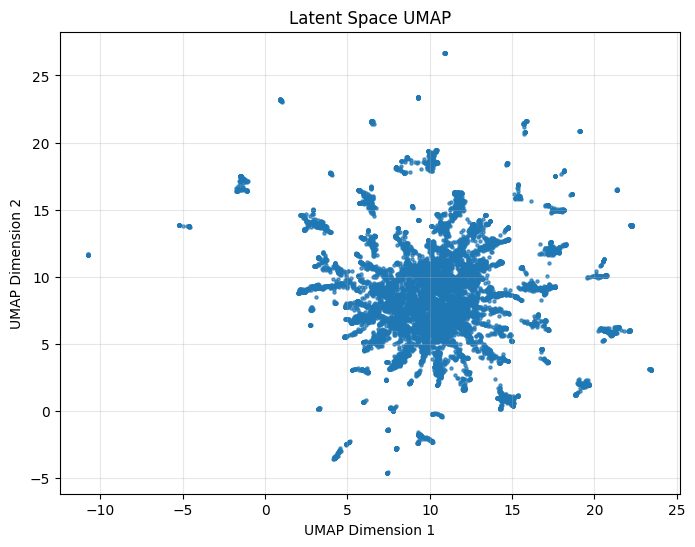

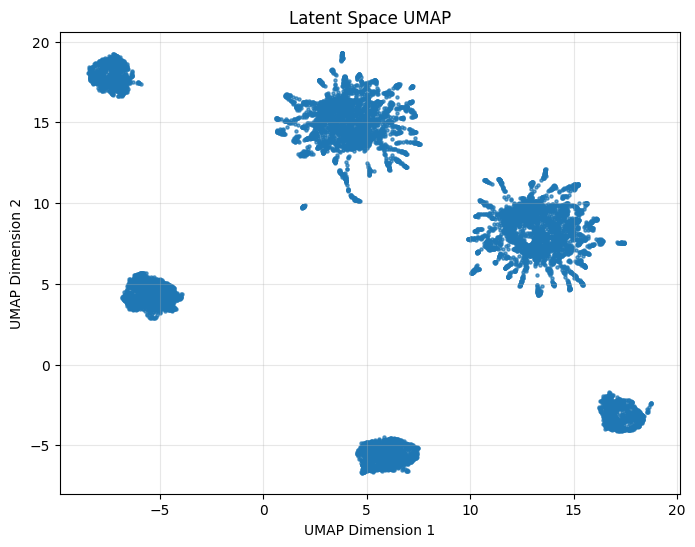

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(umap_embedding_core[:, 0], umap_embedding_core[:, 1], s=5, alpha=0.7)
plt.xlabel("UMAP Dimension 1"); plt.ylabel("UMAP Dimension 2")
plt.title("Latent Space UMAP")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=5, alpha=0.7)
plt.xlabel("UMAP Dimension 1"); plt.ylabel("UMAP Dimension 2")
plt.title("Latent Space UMAP")
plt.grid(True, alpha=0.3)
plt.show()